# Import

In [7]:
import os
import numpy as np
import pandas as pd
import sklearn 

from glob import glob

# vis 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from category_encoders import OrdinalEncoder

# modeling

# Load Data

In [2]:
merge_df = pd.read_csv("/Users/kyujinkim/Downloads/bigcontest_file/loan_result_merge_df.csv")

print("Merged DataFrame Shape :",merge_df.shape) # 13527363 rows × 33 columns

Merged DataFrame Shape : (13527363, 33)


In [3]:
categorical_features = ["bank_id", "product_id", "personal_rehabilitation_complete_yn", "personal_rehabilitation_yn",
                       "houseown_type", "purpose", "employment_type", "income_type", "is_applied", "birth_year",
                       "company_enter_month"]
numerical_features = ["desired_amount", "loan_limit", "loan_rate", "yearly_income", "credit_score", "event"]
drop_features = ["application_id", "user_id"]
date_features = ["date_cd", "insert_time", "loanapply_insert_time"]

print("Length of Categorical Features :", len(categorical_features))
print("Length of Numerical Faetures :", len(numerical_features))
print("Length of Drop Features :", len(drop_features))
print("Length of Date Features :", len(date_features))

Length of Categorical Features : 11
Length of Numerical Faetures : 6
Length of Drop Features : 2
Length of Date Features : 3


In [4]:
df = merge_df.copy()

In [22]:
train_dset = df.copy()

<AxesSubplot:xlabel='credit_score', ylabel='Density'>

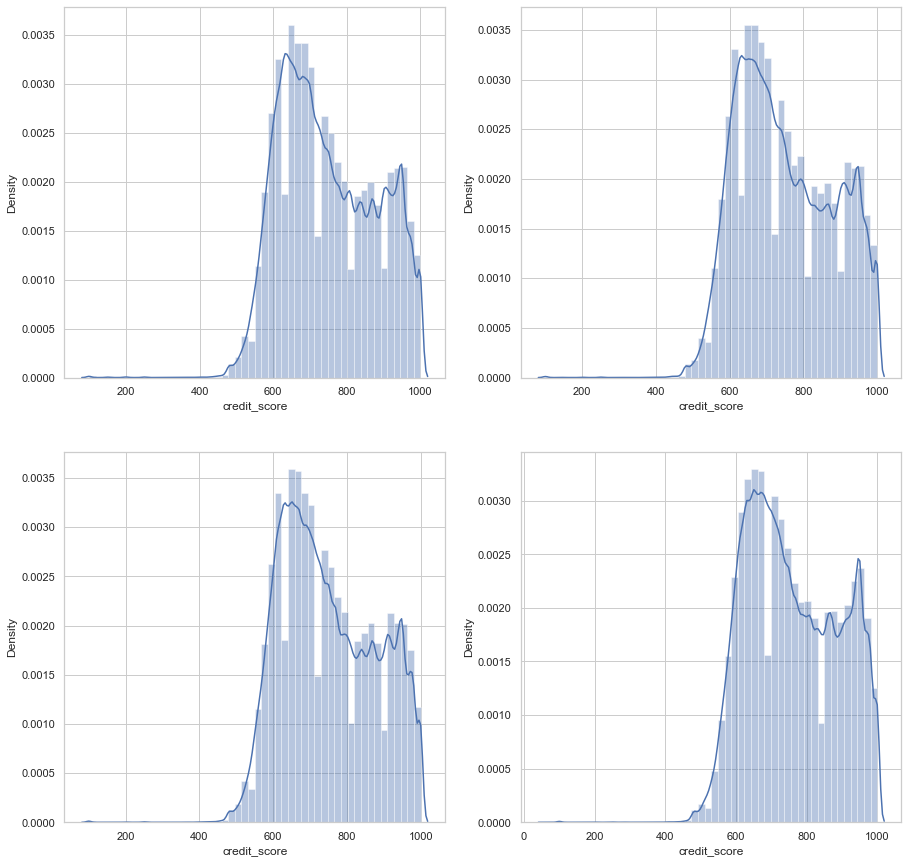

In [25]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize = (15,15))

sns.distplot(train_dset[train_dset['month']==3]['credit_score'], ax=ax[0,0])
sns.distplot(train_dset[train_dset['month']==4]['credit_score'], ax=ax[0,1])
sns.distplot(train_dset[train_dset['month']==5]['credit_score'], ax=ax[1,0])
sns.distplot(train_dset[train_dset['month']==6]['credit_score'], ax=ax[1,1])

<AxesSubplot:xlabel='credit_score', ylabel='Density'>

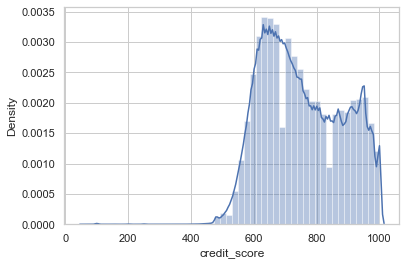

In [26]:
sns.distplot(train_dset['credit_score'])

# 전처리 (label encoding 및 파생변수, 결측치 처리)
- purpose 변수 처리
- birth_year => age_group (연령대 변수 생성)
- company_enter_month (입사연월)
- loanapply_insert_time => 년/월/요일

In [5]:
# purpose 변수
# purpose 8 가지
purpose_dict = {"생활비" : "LIVING",
               "대환대출" : "SWITCHLOAN", 
               "전월세보증금" : "HOUSEDEPOSIT",
               "기타" : "ETC",
               "투자" : "INVEST",
               "자동차구입" : "BUYCAR",
               "주택구입" : "BUYHOUSE",
                "사업자금" : "BUSINESS"}

# np.NaN != np.NaN 성질 활용
df["purpose"] = df["purpose"].apply(lambda x : purpose_dict[x] if x in purpose_dict.keys() else x)
df["purpose"].value_counts().index


# 연차 변수 생성 (company_year)
df["company_enter_month"] = df["company_enter_month"].astype("str")
df["company_year"] = df["company_enter_month"].apply(lambda x : 2022 - float(x[:4]))

# age
df["age"] = df["birth_year"].apply(lambda x : 2022 - x + 1) 
minimum_age = df["age"].min()
maximum_age = df["age"].max()

print("최소 나이 : {}살".format(minimum_age))
print("최대 나이 : {}살".format(maximum_age))

# 연령대 categorical 변수 생성
def age_group(x) : 
    if np.isnan(x) : return np.nan
    if 20 <= x < 30 : return 2
    elif 30 <= x < 40 : return 3
    elif 40 <= x < 50 : return 4
    elif 50 <= x < 60 : return 5
    elif 60 <= x < 70 : return 6 
    elif 70 <= x < 80 : return 7
    elif 80 <= x < 90 : return 8
    else : return 9         
    
df["age_group"] = df["age"].apply(lambda x : age_group(x))
# df["age_group"].value_counts()

df["loanapply_insert_time"] = pd.to_datetime(df["loanapply_insert_time"])

# 연도, 월, 요일 변수 생성
df["year"] = df["loanapply_insert_time"].dt.year
df["month"] = df["loanapply_insert_time"].dt.month
# df["day"] = df["loanapply_insert_time"].dt.weekday
df["day"] = df["loanapply_insert_time"].dt.day_name()

# drop columns
drop_columns = ["personal_rehabilitation_complete_yn", "age", "birth_year", "company_enter_month", 'date_cd', 'time', "insert_time"]
df.drop(drop_columns, axis = 1, inplace = True)

# 중복행 존재 (train 10 개, test 16개)
# train : 제거 필요
print("중복행\n",df.duplicated().value_counts())

최소 나이 : 20.0살
최대 나이 : 93.0살
중복행
 False    13527337
True           26
dtype: int64


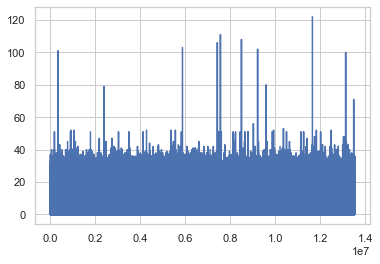

In [8]:
plt.plot(df["company_year"])
plt.show()

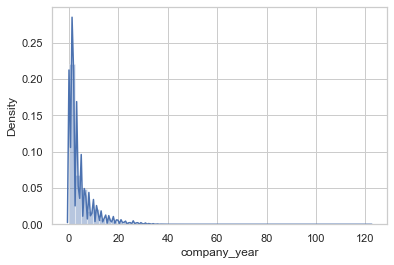

In [12]:
sns.distplot(df["company_year"])
plt.show()

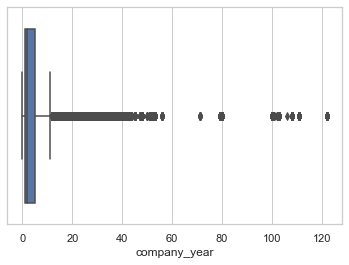

count    1.312691e+07
mean     4.312312e+00
std      5.458182e+00
min      0.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      5.000000e+00
max      1.220000e+02
Name: company_year, dtype: float64

In [17]:
sns.boxplot(df["company_year"])
plt.show()
df["company_year"].describe()

In [14]:
df["company_year"].value_counts()

1.0      3812681
2.0      1794718
0.0      1437147
3.0      1280431
4.0       906684
          ...   
50.0           7
101.0          7
102.0          4
44.0           2
106.0          1
Name: company_year, Length: 64, dtype: int64

In [6]:
# date_columns
time_columns = ["loanapply_insert_time"]

# index_feautres
index_columns = ["application_id", "bank_id", "product_id", "user_id"]

# categorical columns
cat_columns = ["gender", 'year', 'month', 'day', "houseown_type", "company_year", "purpose", "employment_type",
              "income_type", "personal_rehabilitation_yn"]

# numerical columnns
num_columns = ["loan_limit", "loan_rate", 'credit_score', "event", "existing_loan_cnt", "existing_loan_amt",
              "desired_amount", "yearly_income"]

# target_column
target_columns = ["is_applied"]

In [7]:
# loan_limit, loan_rate 결측값 행 제거
df.dropna(subset = ["loan_rate", "loan_limit"], inplace = True)
df["personal_rehabilitation_yn"].fillna(0, inplace = True)

# reset_index
df.reset_index(drop = True, inplace = True)

# Train / Test Split
- 6월 기준
- Data Leakage 방지

In [8]:
train_dset = df.loc[df["loanapply_insert_time"] < "2022-06-01"] 
test_dset = df.loc[df["loanapply_insert_time"] >= "2022-06-01"]

# have to reset index for indexing , slicing
train_dset.reset_index(drop = True, inplace = True)
test_dset.reset_index(drop = True, inplace = True)


Total_dset_size = train_dset.shape[0] + test_dset.shape[0]

train_prob = (train_dset.shape[0] / Total_dset_size)*100
test_prob = (test_dset.shape[0] / Total_dset_size)*100

print("Train Prob : {:.2f}%, Test prob : {:.2f}%".format(train_prob, test_prob))

print("Train : \n\n", train_dset.duplicated().value_counts())
print("Test : \n\n", test_dset.duplicated().value_counts())

# train set 중복행 제거
train_dset.drop_duplicates(keep = "first")

# test 에서는 지우면 안됨

# Train/Test NA prob

train_na = train_dset.isna().sum()
test_na = test_dset.isna().sum()

na_concat = pd.concat([train_na, test_na], axis = 1)
na_concat.rename(columns = {0 : "Train",
                           1 : "Test"}, inplace = True)
train_size = train_dset.shape[0]
test_size = test_dset.shape[0]

na_concat["train_prob"] = na_concat["Train"].apply(lambda x : np.round((x / train_size)*100, 2))
na_concat["test_prob"] = na_concat["Test"].apply(lambda x : np.round((x / test_size)*100, 2))

na_concat

Train Prob : 75.92%, Test prob : 24.08%
Train : 

 False    10264376
True           10
dtype: int64
Test : 

 False    3255466
True          16
dtype: int64


,Train,Test,train_prob,test_prob
application_id,0,0,0.00,0.00
loanapply_insert_time,0,0,0.00,0.00
bank_id,0,0,0.00,0.00
product_id,0,0,0.00,0.00
loan_limit,0,0,0.00,0.00
loan_rate,0,0,0.00,0.00
is_applied,0,3255482,0.00,100.00
user_id,0,0,0.00,0.00
gender,91585,36453,0.89,1.12
credit_score,1243297,265321,12.11,8.15


In [9]:
# # 같은 user_id 는 같은 값이 들어갈 수 있도록 해주기
# grp_user_id_median = train_dset.groupby(["user_id"], as_index = False).median().sort_values("user_id")
# unique_user_id = list(grp_user_id_median["user_id"].values)

# missing_var_ls = ["age_group", "gender", "company_year"]
# # "credit_score", "existing_loan_cnt", "existing_loan_amt" : 결측치 전 후 차이 없음

# for idx, id in enumerate(unique_user_id) : 
#     if idx % 100 == 0 :
#         print(f"{idx + 1}/{len(unique_user_id)} 번째")
#     for missing_var in missing_var_ls : 
#         # median value
#         median_val = grp_user_id_median.iloc[idx][missing_var]
        
#         # idx 
#         indices = train_dset.loc[(train_dset["user_id"] == id) & (train_dset[missing_var].isna())].index
#         train_dset[missing_var].iloc[indices] = median_val
        
#         # test dset
#         indices_test = test_dset.loc[(test_dset["user_id"] == id) & (test_dset[missing_var].isna())].index
#         test_dset[missing_var].iloc[indices_test] = median_val

In [10]:
# !pip install missingno

<AxesSubplot:>

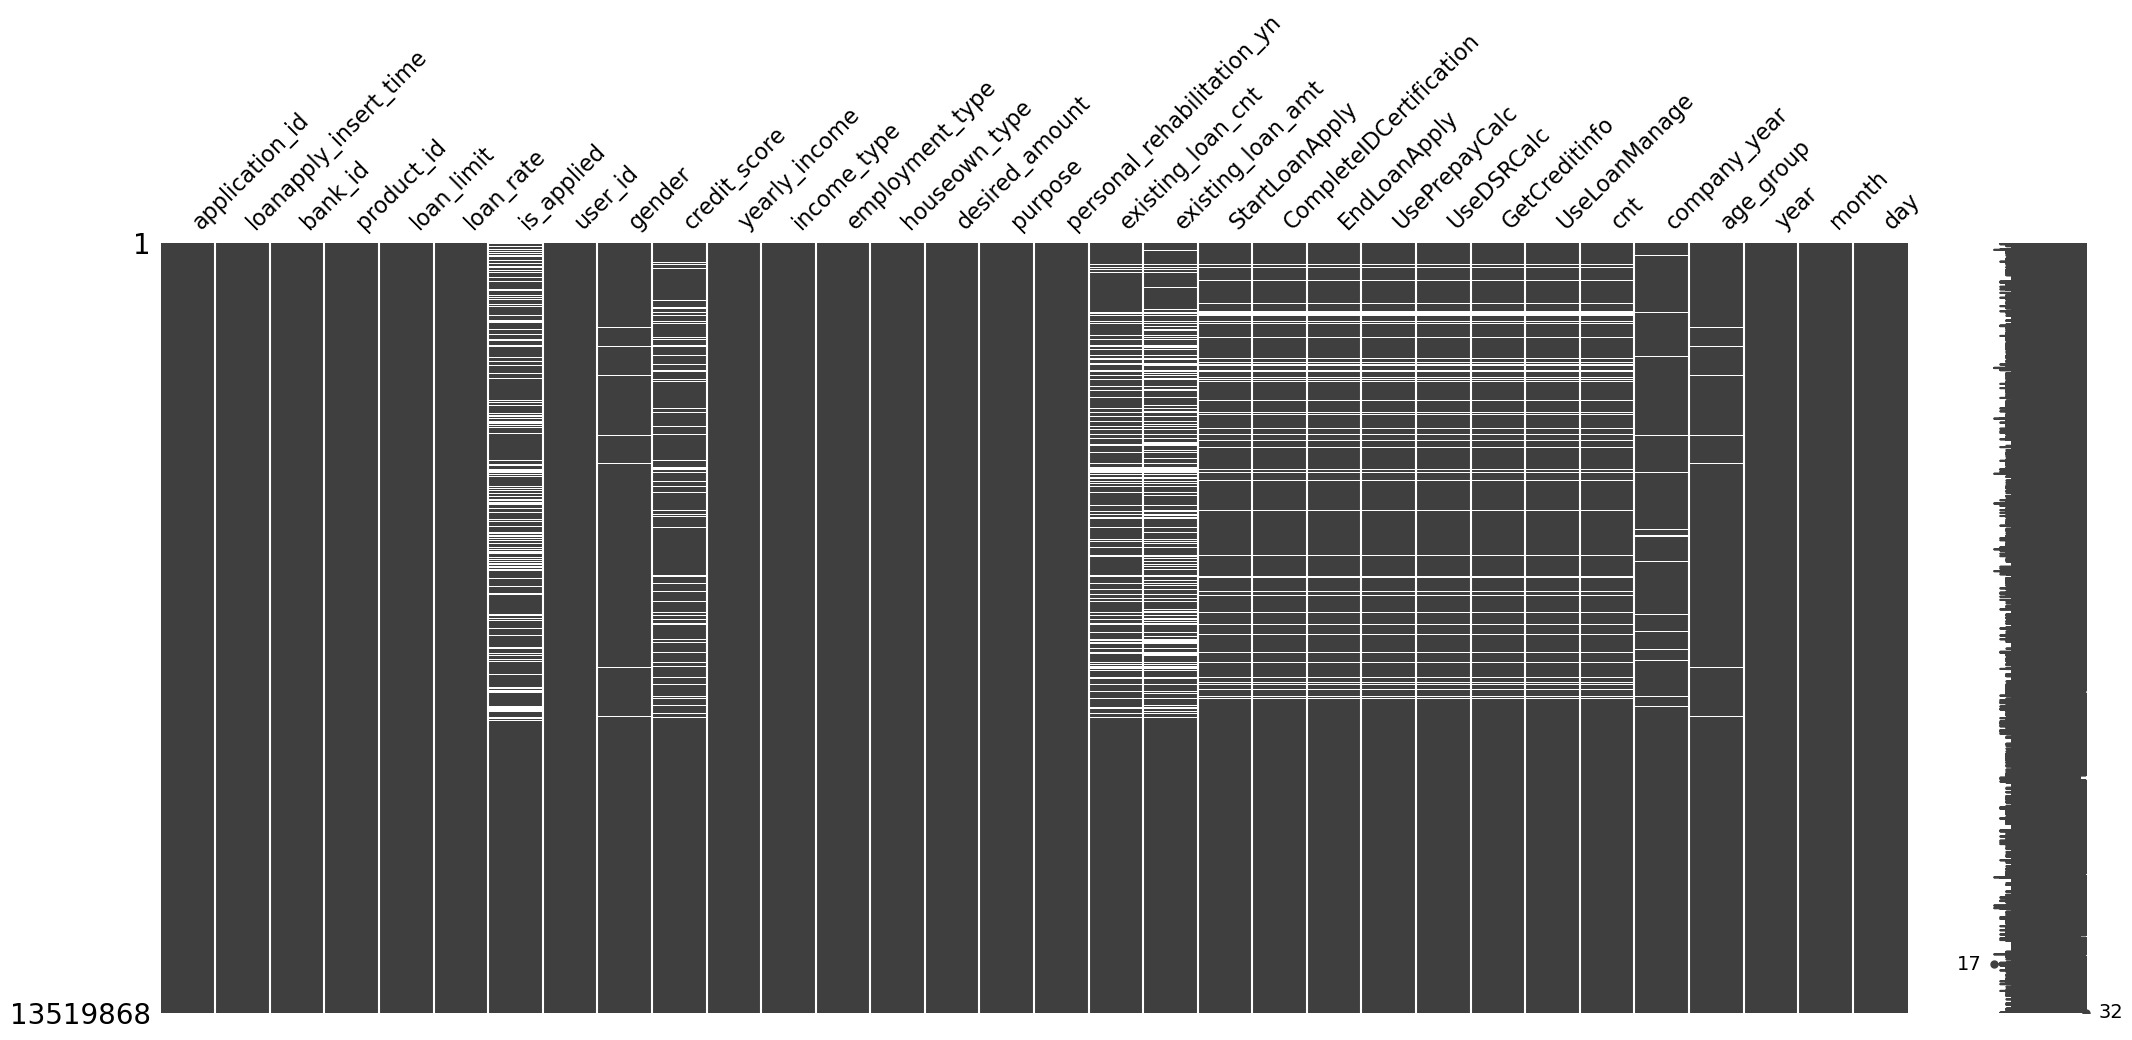

In [13]:
import missingno as msno

msno.matrix(df)

## Simple Imputation

In [14]:
## Simple Imputation

In [14]:
from sklearn.impute import SimpleImputer

cat_cols = ["age_group", "company_year", "gender"]

# Mode Imputation
def imputation_def(col, mode = "most_frequent") : 
    df_mode = train_dset.copy()
    mode_imputer = SimpleImputer(strategy=mode)
    train_dset[col] = mode_imputer.fit_transform(df_mode[col].values.reshape(-1,1))
    test_dset[col] = mode_imputer.transform(test_dset[col].values.reshape(-1,1))
#     # Scatter plot

#     fig = plt.Figure()
#     null_values = df['MaxSpeed'].isnull()
#     fig = df_mode.plot(x='AvgSpeed', y='MaxSpeed', kind='scatter', c=null_values, cmap='winter', title='Mode Imputation', colorbar=False)

for col in cat_cols :
    imputation_def(col)

In [15]:
num_cols = ["credit_score", "yearly_income", "existing_loan_cnt", "existing_loan_amt"]

for col in num_cols :
    imputation_def(col, mode = "median")

In [ ]:
# event 변수들 처리
# 결측치 => 2 로 처리 (결측)
# cnt 변수 : 0 으로 처리

important_event = ["StartLoanApply" , "CompleteIDCertification", "EndLoanApply", "UsePrepayCalc", "UseDSRCalc", "GetCreditinfo", "UseLoanManage"]

for eve in important_event :
    
    train_dset[eve] = train_dset[eve].apply(lambda x : 0 if np.isnan(x) else x)
    test_dset[eve] = test_dset[eve].apply(lambda x : 0 if np.isnan(x) else x)

train_dset["cnt"] = train_dset["cnt"].apply(lambda x : 0 if np.isnan(x) else x)
test_dset["cnt"] = test_dset["cnt"].apply(lambda x : 0 if np.isnan(x) else x)

## KNN / MICE (Multivariate Imputation by Chained Equation)
- one of the most used imputation techinques and also a popular interview question
- MICE first calculates the mean of every column where there is a missing value and uses the mean value as a placeholder. Then it runs a series of regression models (chained equations) to impute each missing value sequentially. Like in any regression model, MICE uses a feature matrix and target variable to train and in this case, the target variable is the column with missing values. MICE predicts and updates missing values on target columns. Iteratively, MICE repeats this process several times by constantly changing the placeholder variables with the predictions from the previous iteration. In the end, it reaches a robust estimation.

In [18]:
# user_spec 변수로 결측치 처리

In [19]:
# 회사 컴으로 돌려보기

### KNN

In [20]:
# # credit_score, existing_loan_cnt, existing_loan_amt
# filter_variable_num = ["credit_score", "yearly_income", "existing_loan_cnt",
#                   "existing_loan_amt", "loan_limit", "loan_rate"]

# # age_group, company_year, gender
# filter_variable_cat = ["age_group", "company_year", "gender", "loan_limit", "loan_rate", "credit_score", "yearly_income",
#                      "existing_loan_cnt", "existing_loan_amt"]

In [21]:
# # Imputing with KNNImputer

# from sklearn.impute import KNNImputer
# from sklearn.preprocessing import MinMaxScaler

# #Define a subset of the dataset
# df_knn = train_dset.filter(filter_variable_num, axis=1).copy()

# # Define scaler to set values between 0 and 1

# scaler = MinMaxScaler(feature_range=(0, 1))
# df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)

# # Define KNN imputer and fill missing values
# knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# knn_imputed_values = knn_imputer.fit_transform(df_knn)
# df_knn_cols = df_knn.columns

# df_knn_imputed = pd.DataFrame(knn_imputed_values, columns=df_knn.columns)

In [22]:
# fig = plt.Figure()
# null_values = train_dset['credit_score'].isnull() 
# fig = df_knn_imputed.plot(x='loan_limit', y='credit_score', kind='scatter', c=null_values, cmap='winter', title='KNN Imputation', colorbar=False)

### MICE

In [23]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# from sklearn import linear_model

# # numerical imputation 먼저
# df_mice = train_dset.filter([filter_variable_num], axis=1).copy()

# # Define MICE Imputer and fill missing values
# mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

# mice_imputed_values = mice_imputer.fit_transform(df_mice)
# df_mice_cols = df_mice.columns

# df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)

In [24]:
# fig = plt.Figure()
# null_values = train_dset['credit_score'].isnull() 
# fig = df_mice_imputed.plot(x='loan_limit', y='credit_score', kind='scatter', c=null_values, cmap='winter', title='MICE Imputation', colorbar=False)

# Save imputated dataframe

In [ ]:
train_dset.to_csv("..\\..\\data\\train_imputed.csv", index = False)
test_dset.to_csv("..\\..\\data\\test_imputed.csv", index = False)